In [ ]:
import pandas as pd
from google.colab import files

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Лабораторная работа 4: Логические методы классификации
Суть: Использование логических методов классификации, таких как решающие деревья и правила принятия решений. Интерпретируемость моделей.

Глубина дерева: Максимальное количество уровней в дереве решений. Чем глубже дерево, тем сложнее модель.

Энтропия: Мера неопределенности данных (высокая энтропия означает, что данные более разнообразны).

Информационный прирост: Уменьшение неопределенности после разделения данных на основе признака.

Разбиение узлов: Процесс деления данных на группы в узлах дерева на основе признака.


In [ ]:
uploaded = files.upload()

Saving iris.data to iris.data


**1. Подключим библиотеки, которые потребуются для загрузки и
первичного анализа данных**

In [ ]:
%matplotlib inline
data_source = 'iris.data'
d = pd.read_table(data_source, delimiter=',', header=None,
names=['sepal_length','sepal_width',
'petal_length', 'petal_width','answer'])
# Содержит только первые четыре столбца (индексы 0, 1, 2 и 3)
dX = d.iloc[ : , 0:4 ]
# Сохраняет целевую переменную
dy = d['answer']
print(dX.head())
print(dy.head())

   sepal_length  sepal_width  petal_length  petal_width
0           5.1          3.5           1.4          0.2
1           4.9          3.0           1.4          0.2
2           4.7          3.2           1.3          0.2
3           4.6          3.1           1.5          0.2
4           5.0          3.6           1.4          0.2
0    Iris-setosa
1    Iris-setosa
2    Iris-setosa
3    Iris-setosa
4    Iris-setosa
Name: answer, dtype: object


**2. Для построения дерева классификации воспользуемся
специальным классом sklearn.tree.DecisionTreeClassifier. Оценими точность
модели методом hold-out (рис. 4.2). Следует обратить внимание, что если в
методе ближайших соседей производилась оптимизация по одному параметру
K – количеству ближайших соседей, то при создании модели
DecisionTreeClassifier необходимо указать два параметра: максимальную
глубину дерева (max_depth) и количество признаков разделения дерева
(max_features).**

In [ ]:
# Класс для построения классификатора на основе решения дерева (decision tree)
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
# Функция для вычисления точности классификатора,
# т.е. насколько правильно классификатор предсказал метки для тестовых данных.
from sklearn.metrics import accuracy_score

#Подмножества для hold-out
X_train, X_holdout, y_train, y_holdout = \
train_test_split(dX, dy, test_size=0.3, random_state=12)

# Обучение модели
# Создание экземпляра классификатора на основе дерева решений с параметрами
tree = DecisionTreeClassifier(max_depth=5,
random_state=21,
max_features=2)
tree.fit(X_train, y_train)
#Получение оценки hold-out
tree_pred = tree.predict(X_holdout)
accur = accuracy_score(y_holdout, tree_pred)
print(accur)

0.9777777777777777


**3. Произведем оценку точности модели по методу cross validation
(рис. 4.3), а также сделаем выводы об оптимальном значении параметра
max_depth.**

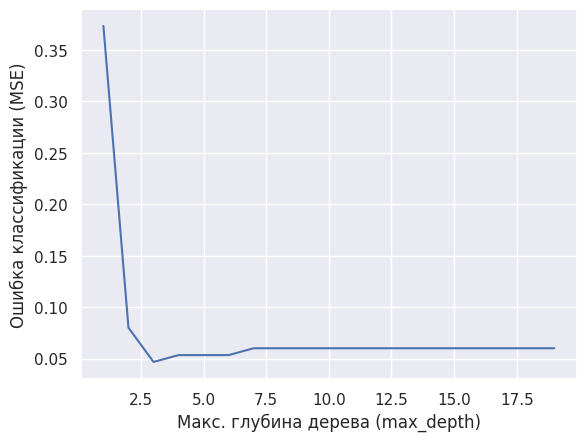

Оптимальные значения max_depth:  [3]


In [ ]:
from sklearn.model_selection import cross_val_score
#Значения параметра max_depth
d_list = list(range(1,20))
# Пустой список для хранения значений точности
cv_scores = []
# В цикле проходим все значения К
for d in d_list:
  tree = DecisionTreeClassifier(max_depth=d,
                            random_state=21,
                            max_features=2)
  scores = cross_val_score(tree, dX, dy, cv=10, scoring='accuracy')
  cv_scores.append(scores.mean())
# Вычисляем ошибку (misclassification error)
MSE = [1-x for x in cv_scores]
# Строим график
plt.plot(d_list, MSE)
plt.xlabel('Макс. глубина дерева (max_depth)');
plt.ylabel('Ошибка классификации (MSE)')
plt.show()

# Ищем минимум
d_min = min(MSE)

# Пробуем найти прочие минимумы (если их несколько)
all_d_min = []
for i in range(len(MSE)):
  if MSE[i] <= d_min:
      all_d_min.append(d_list[i])
# печатаем все К, оптимальные для модели
print('Оптимальные значения max_depth: ', all_d_min)

**4. Оптимальное значение параметра max_depth модели получено, но
в модели присутствует еще один параметр max_features, который был
установлен в значение 2 (не изменялся и не оптимизировался). Для проведения
cross validation по всем параметрам воспользуемся классом GridSearchCV
пакета sklearn.model_selection (рис. 4.5)**

In [ ]:
# GridSearchCV — класс для нахождения оптимальных параметров для модели, перебирая все возможные комбинации в заданном диапазоне.
from sklearn.model_selection import GridSearchCV, cross_val_score
# Модуль, содержащий дерево решений
from sklearn import tree

# Создается классификатор дерева решений с фиксированными параметрами
# Но дальше подбор параметров будет проводиться через GridSearchCV
dtc = DecisionTreeClassifier(max_depth=10, random_state=21, max_features=2)

# Это словарь, который задает диапазоны значений для двух гиперпараметров
tree_params = { 'max_depth': range(1,20), 'max_features': range(1,4) }
# GridSearchCV — выполняет перебор всех возможных комбинаций параметров, указанных в tree_params, и оценивает модель с каждым сочетанием через 10-кратную кросс-валидацию
tree_grid = GridSearchCV(dtc, tree_params, cv=10, verbose=True, n_jobs=-1)
# Обучение модели с использованием кросс-валидации
tree_grid.fit(dX, dy)

print('\n')
# Выводит параметры, которые дали наилучший результат при кросс-валидации
print('Лучшее сочетание параметров: ', tree_grid.best_params_)
# выводит наилучший результат (среднюю точность) кросс-валидации для оптимальных параметров.
print('Лучшие баллы cross validation: ', tree_grid.best_score_)

# Генерируем графическое представление дерева
tree.export_graphviz(tree_grid.best_estimator_,
                     feature_names=dX.columns,
                     class_names=dy.unique(),
                     out_file='iris_tree.dot',
                     filled=True, rounded=True)

Fitting 10 folds for each of 57 candidates, totalling 570 fits


Лучшее сочетание параметров:  {'max_depth': 2, 'max_features': 3}
Лучшие баллы cross validation:  0.9533333333333334


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


**5. Оптимальные параметры определены, можно обучить модель и
использовать ее для классификации (рис. 4.7).**


In [ ]:
# Построим области решения для оптимального дерева
# max_features = 2, max_depth = 3
dtc = DecisionTreeClassifier(max_depth=3, random_state=21, max_features=2)
dtc.fit(dX, dy)
res = dtc.predict(pd.DataFrame([[5.1, 3.5, 1.4, 0.2]], columns=dX.columns))
print(res)

['Iris-setosa']


**6. В заключении построим еще одну визуализацию процесса
логической классификации – покажем решающие границы модели
классификации (рис. 4.8).**

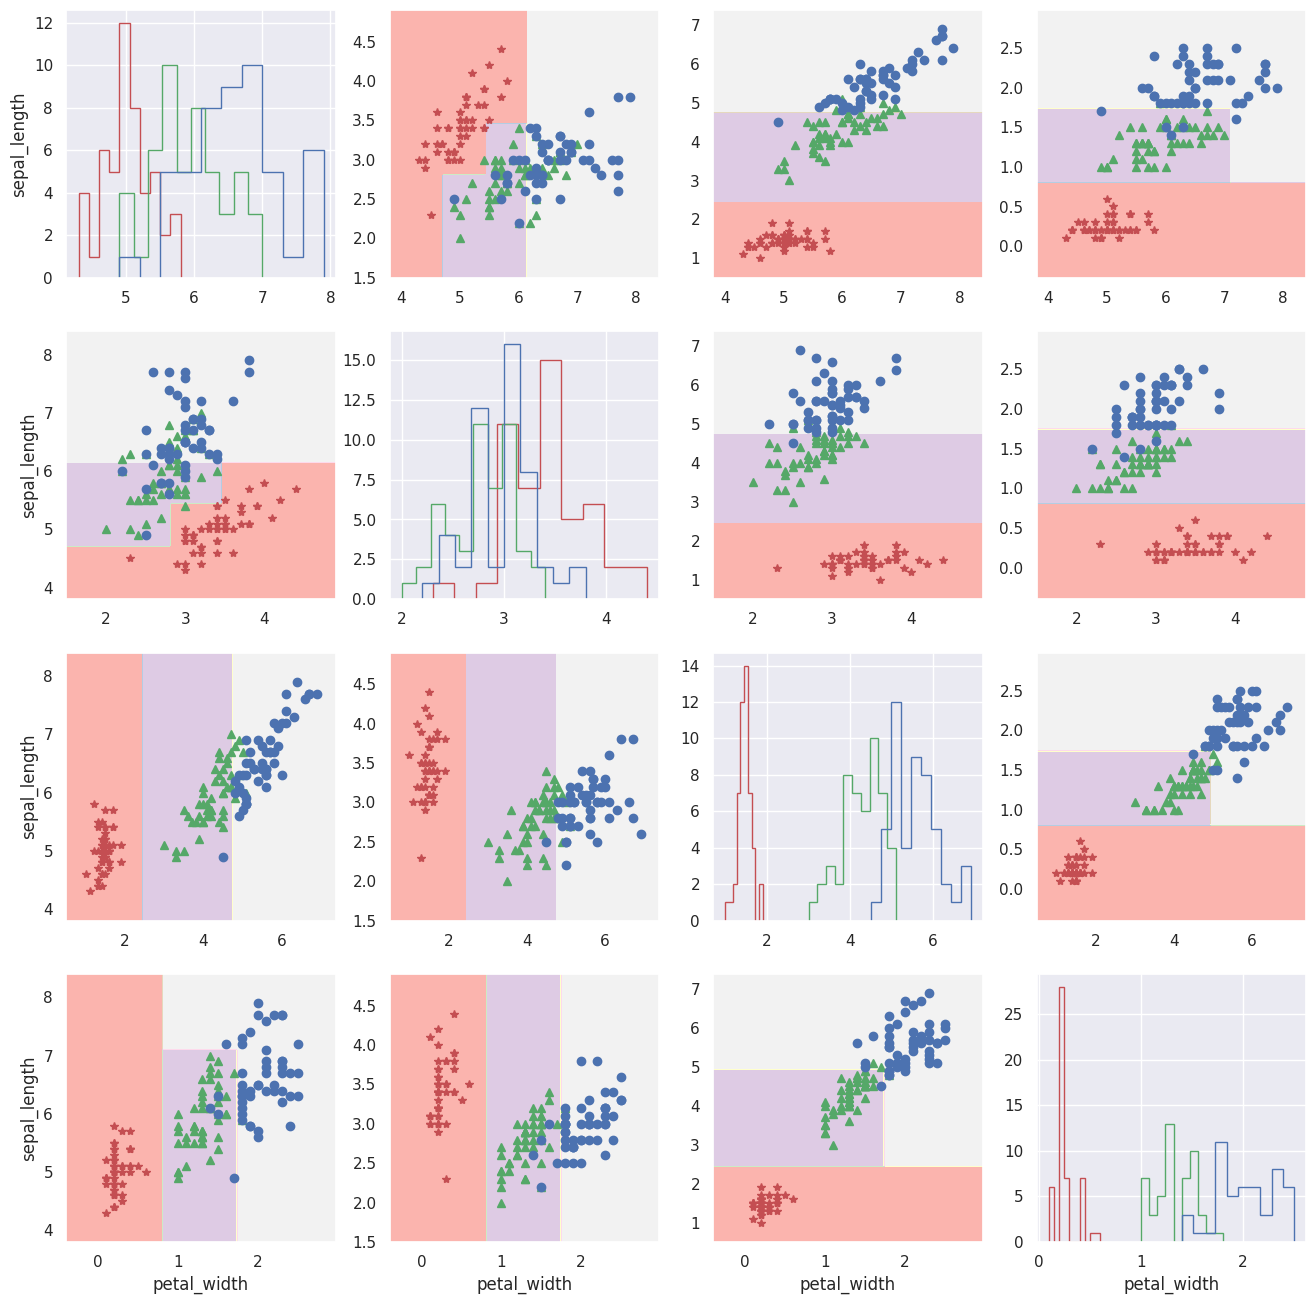

In [ ]:
# plot_markers — список маркеров для различных классов
plot_markers = ['r*', 'g^', 'bo']
# answers — уникальные значения целевой переменной dy
answers = dy.unique()

# Создаем подграфики для каждой пары признаков
# Создается сетка подграфиков 4x4, где каждый подграфик будет представлять собой график для пары признаков.
f, places = plt.subplots(4, 4, figsize=(16, 16))
# Определяются минимальные и максимальные значения признаков с небольшим запасом, чтобы графики не были сжаты.
fmin = dX.min() - 0.5
fmax = dX.max() + 0.5
# Шаг сетки для построения решающих границ модели.
plot_step = 0.02

# Перебираем все возможные пары признаков (всего 4 признака), и для каждой пары создаем подграфик.
for i in range(0, 4):
    for j in range(0, 4):

        # Строим решающие границы
        # Избегаем диагональных подграфиков, где переменные будут одинаковыми.
        if i != j:
          # Генерируем сетку точек для двух признаков, по которым мы хотим построить решающие границы.
            xx, yy = np.meshgrid(
                np.arange(fmin.iloc[i], fmax.iloc[i], plot_step),
                np.arange(fmin.iloc[j], fmax.iloc[j], plot_step)
            )
            # Создаем модель дерева решений с ограничением на максимальную глубину (max_depth=3) и ограничением на количество признаков для использования (max_features=2).
            model = DecisionTreeClassifier(max_depth=3, random_state=21, max_features=2)
            #  Обучаем дерево решений на данных, содержащих только два выбранных признака
            model.fit(dX.iloc[:, [i, j]], dy)

            # Создание DataFrame для предсказаний модели на сетке xx, yy с именами столбцов.
            # Создаем DataFrame для точек сетки, которые будут использоваться для предсказания.
            grid_points = pd.DataFrame(
                np.c_[xx.ravel(), yy.ravel()],
                columns=[dX.columns[i], dX.columns[j]]
            )
            # Предсказываем классы для каждой точки в сетке.
            p = model.predict(grid_points)

            # Преобразование классов в числовые значения
            p_numeric = np.zeros_like(p, dtype=int)
            for idx, label in enumerate(answers):
                p_numeric[p == label] = idx

            p_numeric = p_numeric.reshape(xx.shape)
            #  Рисуем контуры (решающие границы) для каждого подграфика, используя результат предсказания.
            places[i, j].contourf(xx, yy, p_numeric, cmap='Pastel1')

        # Обход всех классов (видов ириса)
        for id_answer in range(len(answers)):
          #  Находим индексы объектов, принадлежащих текущему классу.
            idx = np.where(dy == answers[id_answer])
            # Если текущие признаки совпадают (диагональные подграфики), рисуем гистограмму для каждого класса.
            if i == j:
                places[i, j].hist(
                    dX.iloc[idx].iloc[:, i],
                    color=plot_markers[id_answer][0],
                    histtype='step'
                )
                # Если признаки разные, рисуем точки для каждого класса на соответствующем подграфике с маркерами.
            else:
                places[i, j].plot(
                    dX.iloc[idx].iloc[:, i],
                    dX.iloc[idx].iloc[:, j],
                    plot_markers[id_answer],
                    label=answers[id_answer],
                    markersize=6
                )

        # Подписи осей
        if j == 0:
            places[i, j].set_ylabel(dX.columns[j]) # Подпись оси Y для текущего признака.
        if i == 3:
            places[i, j].set_xlabel(dX.columns[i]) # Подпись оси X для текущего признака.

**ИНДИВИДУАЛЬНОЕ ЗАДАНИЕ**

**Подготовка данных**

In [ ]:
uploaded = files.upload()

Saving WineQT.csv to WineQT.csv


In [ ]:
import pandas as pd

# Загрузка данных
data_source = 'WineQT.csv'  # Убедись, что путь к файлу правильный
data = pd.read_csv(data_source)

# Отбор признаков и целевого признака
X = data.drop(columns=['quality', 'Id'])  # Удаляем столбцы, которые не нужны для классификации
y = data['quality']  # Целевой признак

# Проверка данных
print(X.head())
print(y.head())


   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  
0      9.4  
1      9.8  
2      9.8  
3      9.8  
4      9.4  
0    5
1

**ПОИСК ОПТИМАЛЬНЫХ ЗНАЧЕНИЙ max_depth и features:**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import graphviz

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Параметры дерева: поиск оптимальных значений max_depth и max_features
max_depth_values = [3, 5, 7, 10, None]  # Возможные значения max_depth
max_features_values = [1, 3, 'sqrt', 'log2', None]  # Возможные значения max_features

best_accuracy = 0
best_max_depth = None
best_max_features = None

# Проходим по всем возможным значениям max_depth и max_features
for max_depth in max_depth_values:
    for max_features in max_features_values:
        # Построение дерева решений с текущими параметрами
        tree_clf = DecisionTreeClassifier(max_depth=max_depth, max_features=max_features, random_state=42)
        tree_clf.fit(X_train, y_train)

        # Предсказание на тестовых данных
        y_pred = tree_clf.predict(X_test)

        # Оценка качества модели
        accuracy = accuracy_score(y_test, y_pred)

        # Сохраняем параметры с наилучшей точностью
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_max_depth = max_depth
            best_max_features = max_features

# Выводим лучшие параметры
print(f"Лучшие параметры: max_depth = {best_max_depth}, max_features = {best_max_features}")
print(f"Точность модели: {best_accuracy}")

# Построение лучшего дерева с оптимальными параметрами
best_tree_clf = DecisionTreeClassifier(max_depth=best_max_depth, max_features=best_max_features, random_state=42)
best_tree_clf.fit(X_train, y_train)

# Визуализация лучшего дерева
dot_data = export_graphviz(
    best_tree_clf, out_file=None,
    feature_names=X.columns,
    class_names=[str(i) for i in y.unique()],
    filled=True, rounded=True,
    special_characters=True
)
graph = graphviz.Source(dot_data)
graph.render("best_decision_tree", format="png")  # Сохранение дерева в формате PNG
print("Лучшее дерево сохранено в формате PNG.")


Лучшие параметры: max_depth = 5, max_features = None
Точность модели: 0.5947521865889213
Лучшее дерево сохранено в формате PNG.


**Вычисление оценки cross-validation (MSE) для разных значений max_depth**

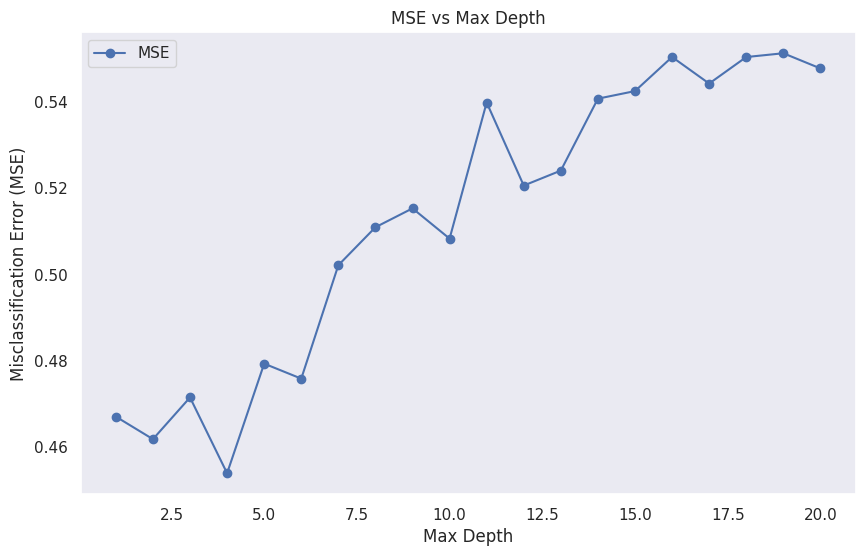

In [ ]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

# Тестирование разных значений max_depth
depth_range = range(1, 21)  # Диапазон значений max_depth от 1 до 20
mse_scores_depth = []  # Список для хранения ошибок классификации (MSE) для каждой глубины

# Перебираем все значения max_depth из заданного диапазона
for depth in depth_range:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)  # Создаем классификатор с данным max_depth
    # Оцениваем точность модели с помощью кросс-валидации с 6 фолдами
    scores = cross_val_score(clf, X, y, cv=6, scoring='accuracy')
    # Вычисляем среднюю ошибку классификации (MSE), которая равна: MSE = 1 - accuracy
    mse_scores_depth.append(1 - scores.mean())

# График зависимости MSE от max_depth
plt.figure(figsize=(10, 6))
plt.plot(depth_range, mse_scores_depth, marker='o', label="MSE")
plt.xlabel('Max Depth')
plt.ylabel('Misclassification Error (MSE)')
plt.title('MSE vs Max Depth')
plt.legend()  # Добавляем легенду
plt.grid()
plt.show()


**Вычисление оценки cross-validation (MSE) для разных значений max_features (пункт 2.3)**


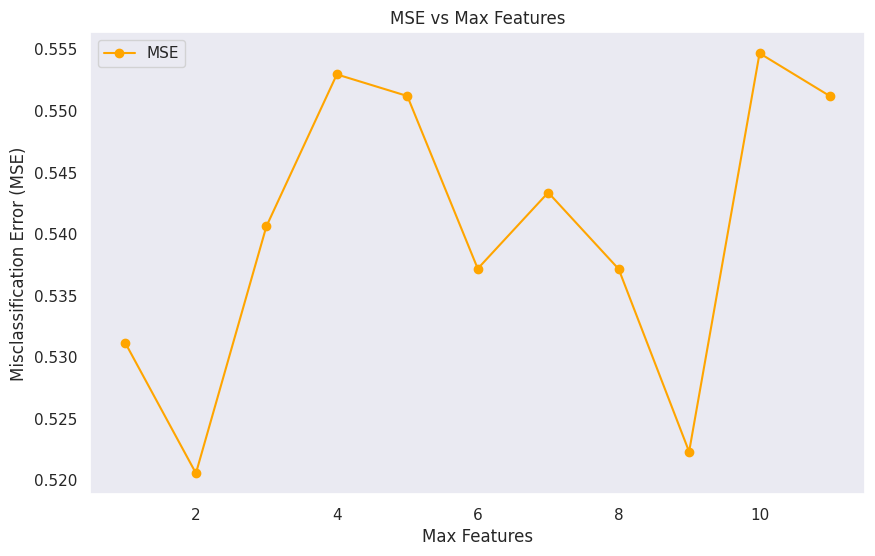

In [ ]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

# Тестирование разных значений max_features
features_range = range(1, X.shape[1] + 1)  # X.shape[1] — общее количество признаков в наборе данных.
mse_scores_features = []  # Список для хранения ошибок классификации (MSE) для каждого значения max_features

# Перебираем все значения max_features из заданного диапазона
for features in features_range:
    clf = DecisionTreeClassifier(max_depth=max_depth, max_features=features, random_state=42)  # Создаем классификатор с данным max_features
    # Оцениваем точность модели с помощью кросс-валидации с 6 фолдами
    scores = cross_val_score(clf, X, y, cv=6, scoring='accuracy')
    # Вычисляем среднюю ошибку классификации (MSE), которая равна: MSE = 1 - accuracy
    mse_scores_features.append(1 - scores.mean())

# График зависимости MSE от max_features
plt.figure(figsize=(10, 6))
plt.plot(features_range, mse_scores_features, marker='o', color='orange', label="MSE")
plt.xlabel('Max Features')
plt.ylabel('Misclassification Error (MSE)')
plt.title('MSE vs Max Features')
plt.legend()  # Добавляем легенду
plt.grid()
plt.show()


In [ ]:
# Печать столбцов признаков (X)
print("Столбцы признаков (X):", X.columns.tolist())  # Преобразует объект Index в список

# Печать количества признаков в X
print("Количество признаков в X:", X.shape[1])  # Возвращает количество признаков (столбцов) в DataFrame


Столбцы признаков (X): ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
Количество признаков в X: 11


**Оптимальные значения max_depth и max_features**

In [ ]:
# Минимум MSE для max_depth
optimal_depth = depth_range[mse_scores_depth.index(min(mse_scores_depth))]

# Минимум MSE для max_features
optimal_features = features_range[mse_scores_features.index(min(mse_scores_features))]

# Выводим оптимальные значения
print(f"Оптимальное значение max_depth: {optimal_depth}")
print(f"Оптимальное значение max_features: {optimal_features}")


Оптимальное значение max_depth: 4
Оптимальное значение max_features: 2


In [ ]:
# Построение дерева с оптимальными параметрами
optimal_tree_clf = DecisionTreeClassifier(max_depth=optimal_depth, max_features=optimal_features, random_state=42)

# Обучаем дерево решений на тренировочном наборе данных
optimal_tree_clf.fit(X_train, y_train)

# Визуализация дерева
dot_data = export_graphviz(
    optimal_tree_clf, out_file=None,
    feature_names=X.columns,
    class_names=[str(cls) for cls in y.unique()],  # Преобразуем классы в строки
    filled=True, rounded=True,
    special_characters=True
)

# Преобразуем текст в формате DOT в объект графа для визуализации
graph = graphviz.Source(dot_data)

# Сохраняем дерево в формате PNG
graph.render("optimal_decision_tree", format="png")

print("Оптимальное дерево сохранено в формате PNG.")


Оптимальное дерево сохранено в формате PNG.


**Вывод решающих границ**

Для построения решающих границ необходимо ограничиться двумя признаками для визуализации.

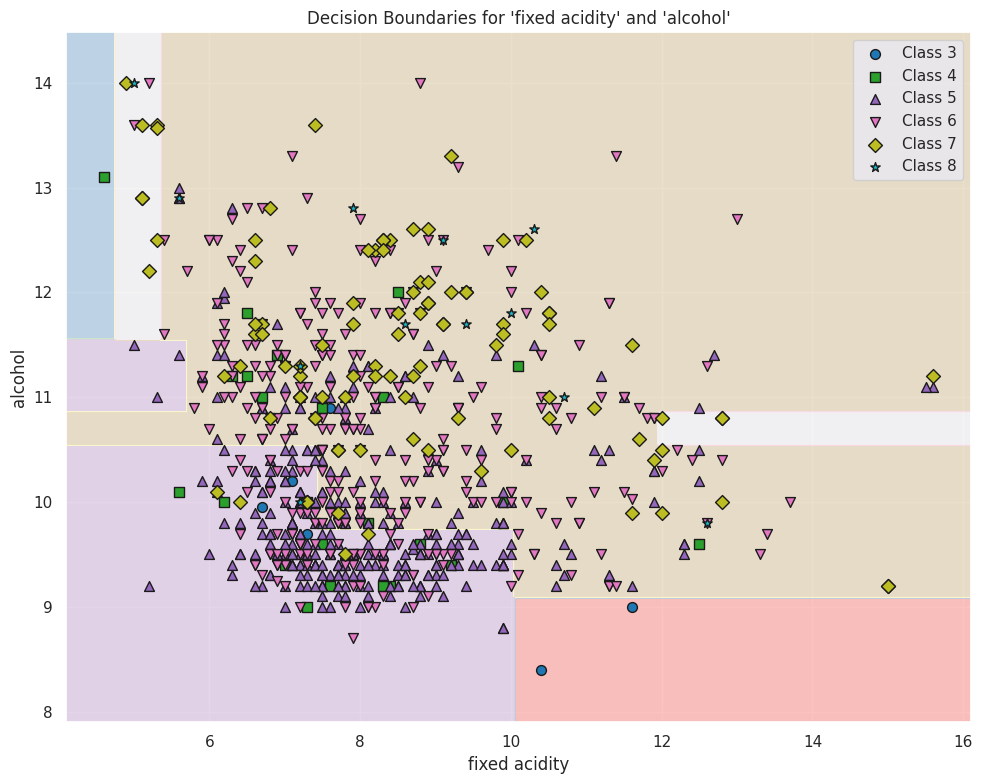

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Выбор двух признаков для визуализации
X_subset = X[['fixed acidity', 'alcohol']]
feature_names = ['fixed acidity', 'alcohol']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.3, random_state=42)

# Генерация маркеров и цветов для классов
answers = np.unique(y_train)  # Уникальные классы
plot_colors = plt.cm.tab10(np.linspace(0, 1, len(answers)))  # Динамическая палитра
plot_markers = ['o', 's', '^', 'v', 'D', '*', 'X', 'P', '<', '>']  # Запас маркеров

# Параметры построения графика
fmin = X_train.min() - 0.5  # Минимум для сетки с небольшим отступом
fmax = X_train.max() + 0.5  # Максимум для сетки с небольшим отступом
plot_step = 0.02  # Шаг сетки

# Создание координатной сетки для отображения границ классификации
xx, yy = np.meshgrid(
    np.arange(fmin[feature_names[0]], fmax[feature_names[0]], plot_step),
    np.arange(fmin[feature_names[1]], fmax[feature_names[1]], plot_step)
)

# Создание и обучение дерева решений
model = DecisionTreeClassifier(max_depth=optimal_depth, max_features=optimal_features, random_state=42)
model.fit(X_train, y_train)

# Преобразуем сетку координат в формат DataFrame
grid_points = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=feature_names)

# Предсказание классов для всех точек сетки
predictions = model.predict(grid_points)

# Преобразуем предсказания в числовой формат
predictions_numeric = np.zeros_like(predictions, dtype=int)
for idx, label in enumerate(answers):
    predictions_numeric[predictions == label] = idx

# Формируем карту предсказаний
predictions_numeric = predictions_numeric.reshape(xx.shape)

# Построение графика
plt.figure(figsize=(10, 8))

# Отображаем решающие границы как заливку цветами
plt.contourf(xx, yy, predictions_numeric, cmap='Pastel1', alpha=0.8)

# Отображаем данные
for id_answer, answer in enumerate(answers):
    idx = np.where(y_train == answer)[0]  # Находим индексы классов
    plt.scatter(
        X_train.iloc[idx, 0],  # Значения первого признака
        X_train.iloc[idx, 1],  # Значения второго признака
        c=[plot_colors[id_answer]],  # Цвет для текущего класса
        label=f"Class {answer}",  # Метка для текущего класса
        marker=plot_markers[id_answer % len(plot_markers)],  # Выбор маркера
        edgecolor='k',  # Черный контур маркера
        s=50  # Размер точек
    )

# Подписи осей
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.title("Decision Boundaries for 'fixed acidity' and 'alcohol'")
plt.legend()
plt.tight_layout()
plt.show()


График показывает, как дерево решений разделяет пространство признаков 'fixed acidity' и 'alcohol' для различных классов. Некоторые классы имеют четкие разделяющие границы, в то время как другие, такие как класс 3, менее точно разделены, что может указывать на наличие сложных для классификации областей. В целом, модель хорошо работает с этими признаками, но для улучшения точности могут потребоваться дополнительные данные или признаки.